In [38]:
import pandas as pd
import numpy as np
import os
from scipy import signal
from scipy.fft import fftshift
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  2
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:63:00.0, compute capability: 7.5



2022-05-05 00:15:34.421733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9644 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5
2022-05-05 00:15:34.423277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9644 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:63:00.0, compute capability: 7.5


# Test Train Split

In [3]:
# Load data from cleaned pickles
database = pd.read_pickle('data/database.pkl')
ecg_data = pd.read_pickle('data/ecg_data.pkl')

# Convert data to arrays
X = np.array(ecg_data)
Y = np.array(database['subclass'])

In [6]:
val_fold  = [8,9]
test_fold = [10] 

train_idx = np.where(np.isin(database['strat_fold'], val_fold+test_fold, invert=True))
val_idx = np.where(np.isin(database['strat_fold'], val_fold))
test_idx = np.where(np.isin(database['strat_fold'], test_fold))

X_train = list(X[train_idx])
X_val   = list(X[val_idx])
X_test  = list(X[test_idx])
Y_train = list(Y[train_idx])
Y_val   = list(Y[val_idx])
Y_test  = list(Y[test_idx])

# Read true labels for predictions

In [29]:
path = '/project/GutIntelligenceLab/bwl3xy/ecg'
os.chdir(path)

In [30]:
# Get true labels
test_fold = [10] 
test_idx = np.where(np.isin(database['strat_fold'], test_fold))
y_true  = list(Y[test_idx])

In [31]:
label_map = {'NORM': 0, 'MI': 1, 'STTC': 2, 'HYP': 3, 'CD': 4}
label_list = list(label_map.keys())

# Spectrogram

In [14]:
def ecg_to_spec(ecg, nperseg=250, noverlap=50):
    n_leads = ecg.shape[0]
    spec = []
    for i in range(n_leads):
        f, t, Sxx = signal.spectrogram(ecg[i,:], nperseg=nperseg, noverlap=noverlap)
        spec.append(Sxx)
    return np.array(spec)

def apply_ecg_to_spec(ecg_array, nperseg=50, noverlap=25):
    spec_list = []
    for ecg in ecg_array:
        spec_list.append(ecg_to_spec(ecg, nperseg, noverlap))
    return spec_list

In [15]:
X_train_spec = apply_ecg_to_spec(X_train)
X_val_spec = apply_ecg_to_spec(X_val)
X_test_spec = apply_ecg_to_spec(X_test)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_spec, Y_train))
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val_spec, Y_val))
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test_spec, Y_test))

2022-05-04 23:59:11.286954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9644 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5
2022-05-04 23:59:11.288451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9644 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:63:00.0, compute capability: 7.5


In [17]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(1)

In [22]:
num_classes = len(np.unique(Y))
input_shape = X_train_spec[0].shape

print('num_classes =', num_classes)
print('input_shape =', input_shape)

num_classes = 5
input_shape = (12, 26, 39)


## Inception Model 2d

In [35]:
dropout_rate=0.25

def inception2d(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1,1), padding='same')(layer_in)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation('relu')(conv1)
    conv1 = keras.layers.Dropout(rate=dropout_rate)(conv1)

    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same')(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(rate=dropout_rate)(conv3)

    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same')(conv5)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.Activation('relu')(conv5)
    conv5 = keras.layers.Dropout(rate=dropout_rate)(conv5)

    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same')(pool)
    pool = keras.layers.BatchNormalization()(pool)
    pool = keras.layers.Activation('relu')(pool)

    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    return layer_out
 

visible = Input(shape=input_shape)
layer = inception2d(visible, 64, 96, 128, 16, 32, 32)
layer = inception2d(layer, 128, 128, 192, 32, 96, 64)

#flatten activation map
#dense layer 
#sigmoid activation 

output = keras.layers.Flatten()(layer)
out = keras.layers.Dense(num_classes, activation='softmax')(output)
model = Model(inputs=visible, outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 26, 39)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 12, 26, 96)   3840        ['input_4[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 12, 26, 16)   640         ['input_4[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 12, 26, 64)   2560        ['input_4[0][0]']          

In [36]:
epochs=30
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = epochs)


epochs = 30
model_output = 'models/inception_2d.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/30
463/463 [==============================] - 7s 12ms/step - loss: 2.6109 - accuracy: 0.4874 - val_loss: 1.3435 - val_accuracy: 0.5216
Epoch 2/30
463/463 [==============================] - 5s 11ms/step - loss: 1.2516 - accuracy: 0.5655 - val_loss: 1.2088 - val_accuracy: 0.5796
Epoch 3/30
463/463 [==============================] - 5s 11ms/step - loss: 1.0786 - accuracy: 0.5988 - val_loss: 1.1395 - val_accuracy: 0.5753
Epoch 4/30
463/463 [==============================] - 5s 11ms/step - loss: 1.0120 - accuracy: 0.6244 - val_loss: 1.1868 - val_accuracy: 0.5485
Epoch 5/30
463/463 [==============================] - 5s 11ms/step - loss: 0.9455 - accuracy: 0.6443 - val_loss: 0.9997 - val_accuracy: 0.6171
Epoch 6/30
463/463 [==============================] - 5s 11ms/step - loss: 0.9125 - accuracy: 0.6604 - val_loss: 1.0228 - val_accuracy: 0.6060
Epoch 7/30
463/463 [==============================] - 5s 11ms/step - loss: 0.8716 - accuracy: 0.6769 - val_loss: 0.9918 - val_accuracy: 0.6220

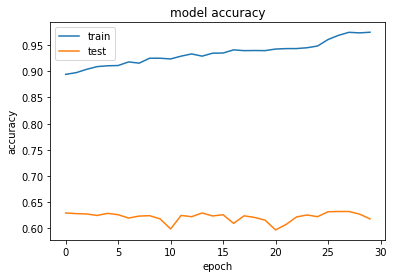

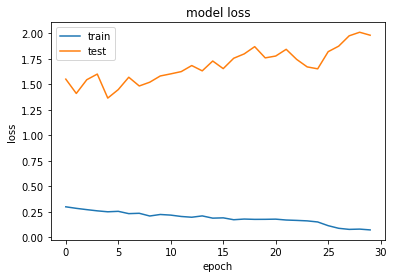

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# model = tf.keras.models.load_model('models/basic_cnn.h5')
model.evaluate(test_dataset)

2138/2138 [==============================] - 5s 2ms/step - loss: 2.2013 - accuracy: 0.6066


[2.2013046741485596, 0.6066417098045349]

In [43]:
y_preds = model.predict(test_dataset)

In [44]:
# NEED TO CONVER THIS TO HARD PREDICTIONS TO FEED INTO CLASSIFICATION REPORT

y_preds

array([[9.98262227e-01, 1.38044241e-03, 7.12619208e-09, 1.64385006e-09,
        3.57363053e-04],
       [9.88497376e-01, 8.72967008e-04, 2.62062240e-04, 5.51578996e-04,
        9.81604774e-03],
       [9.64801431e-01, 5.71628392e-04, 2.03584705e-06, 1.97158544e-03,
        3.26532945e-02],
       ...,
       [3.56356390e-02, 2.72241533e-01, 3.17761377e-02, 6.32201314e-01,
        2.81453449e-02],
       [1.10661273e-03, 1.84295404e-05, 1.14027462e-05, 3.76525946e-04,
        9.98486996e-01],
       [7.87029101e-04, 7.16754377e-01, 1.90654027e-04, 1.17782954e-04,
        2.82150120e-01]], dtype=float32)

In [157]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.5944808231992517

In [158]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.703     0.936     0.803       921
         IMI      0.380     0.420     0.399       207
        STTC      0.378     0.541     0.445       181
        NST_      0.000     0.000     0.000        46
         LVH      0.430     0.490     0.458       100
   LAFB/LPFB      0.619     0.148     0.239        88
       IRBBB      0.417     0.160     0.231        94
        IVCD      0.000     0.000     0.000        36
         AMI      0.586     0.337     0.428       193
        _AVB      0.000     0.000     0.000        23
        ISCA      0.246     0.237     0.241        59
        ISCI      0.000     0.000     0.000        18
       CRBBB      0.744     0.674     0.707        43
       CLBBB      0.867     0.736     0.796        53
     RAO/RAE      0.000     0.000     0.000         4
         RVH      0.000     0.000     0.000         3
        ISC_      0.000     0.000     0.000        47
       ILBBB      0.000    